In [1]:
import fasttext
import numpy as np
import sys
import matplotlib.pylab as plt
%matplotlib inline
sys.path.append('..')

In [2]:
import logging
log_format = '[%(asctime)s] [%(levelname)s] - %(message)s'
logging.basicConfig(level=logging.DEBUG, format=log_format)
log = logging.getLogger(__name__)

# writing to stdout
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
handler.setFormatter(log_format)
log.addHandler(handler)
logging.debug('test logging message')

[2020-01-31 23:11:43,571] [DEBUG] - test logging message


In [3]:
model = fasttext.load_model('/home/legin/fasttext/wiki.en.bin')
#model = fasttext.load_model('../test_lenin/lenin.bin')

In [4]:
import compressors.dumb  as dumb 
#import compressors.compressor8 as d 
import storages.shelve_based as db
#from importlib import reload
#reload(d)

In [5]:
rs = np.random.RandomState(42)
all_words = sorted(model.words)
words_subset = [all_words[i] for i in rs.choice(len(all_words), 10000, replace=False)]

In [6]:
words_subset[:100]

['dorstener',
 'troieshchyna',
 '科擧',
 'workprints',
 'haiyue',
 'doxbridge',
 'rashleighs',
 'shankho',
 'talegalli',
 'bigsoccer',
 'dipolarophile',
 'sulaymān',
 'pseudoaneurysms',
 'juramento',
 'olivelawn',
 'farbenfinsternis',
 'коррупции',
 'robigoog',
 'shipping/receiving',
 'seolwon',
 'uclu',
 'novatt',
 'taote',
 'spygate',
 'jtmoon',
 'sunwatch',
 'ialmenus',
 'ansariya',
 'kaikorai',
 'kolkáreň',
 'amygdalia',
 'abdulghafoor',
 'gandzasar',
 'obamas',
 'expertone',
 'ardeirhynchus',
 'mladena',
 'egerszóláti',
 '/faqs',
 'patienter',
 'monsterjam',
 'tomko',
 'gaztransport',
 'oakfurnitureonline',
 'dunglison',
 'dreams',
 'yatasi',
 'lipoedema',
 'argyrotype',
 'schenker/klaus',
 'drachman',
 'ncso',
 '/split',
 'eukelade',
 'premierships',
 'gazikentspor',
 'rocanrol',
 'heinämaa',
 'hemvägen',
 'detering',
 'scirpus',
 'gunzbourg',
 'reftype',
 'leevicious',
 'playpack',
 'mahtāb',
 'reli',
 'pogovorim',
 'tympanohyal',
 'creation/elsa',
 'détaché',
 'dramaworld',
 'avg

In [6]:
from scipy.spatial.distance import cosine 
def eval_model():
    cos = []
    eucl = []
    for w in words_subset:
        #print (w)
        v1 = model[w]
        v2 = dc[w]
        c = cosine(v1,v2)
        e = np.linalg.norm(v1-v2)
        cos.append(c)
        eucl.append(e)
    return cos, eucl 


In [7]:
import pickle
help(pickle)

Help on module pickle:

NAME
    pickle - Create portable serialized representations of Python objects.

MODULE REFERENCE
    https://docs.python.org/3.5/library/pickle.html
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    See module copyreg for a mechanism for registering custom picklers.
    See module pickletools source for extensive comments.
    
    Classes:
    
        Pickler
        Unpickler
    
    Functions:
    
        dump(object, file)
        dumps(object) -> string
        load(file) -> object
        loads(string) -> object
    
    Misc variables:
    
        __version__
        format_version
        compatible_formats

CLASSES
    builtins.Exception(builtins.BaseException)


In [8]:
import pickle
import os 
db_name = './test_db'
result = {}
for take_every in [1,5,10,50,100]:
    for word_ngrams in [True, False]:
        os.system('rm -r {0}'.format(db_name))
        dc = dumb.DumbCompressor(db.ShelveStorage(db_name, 'c'))
        dc.fit(model, word_ngrams, take_every)
        cos, eucl = eval_model()
        result[(take_every, word_ngrams)] = cos, eucl
        with open('results_dumb.pckl', 'wb') as out:
            pickle.dump(result, out)

[2020-01-31 23:12:22,627] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [00:59<00:00, 33762.30it/s]
[2020-01-31 23:13:21,877] [DEBUG] - loading words
100%|██████████| 2519370/2519370 [02:19<00:00, 18034.03it/s]
[2020-01-31 23:15:41,579] [DEBUG] - ready
[2020-01-31 23:15:59,591] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [01:19<00:00, 25006.90it/s]
[2020-01-31 23:17:19,571] [DEBUG] - ready
/usr/local/lib/python3.5/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
[2020-01-31 23:17:31,693] [DEBUG] - loading ngrams
100%|██████████| 400000/400000 [00:07<00:00, 53700.83it/s]
[2020-01-31 23:17:39,144] [DEBUG] - loading words
100%|██████████| 2519370/2519370 [00:49<00:00, 51031.87it/s]
[2020-01-31 23:18:28,514] [DEBUG] - ready
[2020-01-31 23:18:36,983] [DEBUG] - loading ngrams
100%|██████████| 400000/400000 [00:07<00:00, 53409.88it/s]
[2020-01-31 23:18:44,475] [DEBUG] - ready

In [9]:
import pickle
with open('results_dumb.pckl', 'rb') as inp:
    result = pickle.load(inp)

In [10]:
del model

 31%|███       | 768992/2519370 [00:30<00:50, 34699.78it/s]

In [13]:
import gc
gc.collect()

0

In [10]:
result.keys()

dict_keys([(50, False), (5, False), (10, True), (10, False), (5, True), (1, False), (100, True), (1, True), (50, True), (100, False)])

[2020-01-31 23:31:22,702] [DEBUG] - update_title_pos
[2020-01-31 23:31:22,729] [DEBUG] - update_title_pos
[2020-01-31 23:31:22,756] [DEBUG] - update_title_pos
[2020-01-31 23:31:22,778] [DEBUG] - update_title_pos
[2020-01-31 23:31:22,789] [DEBUG] - update_title_pos


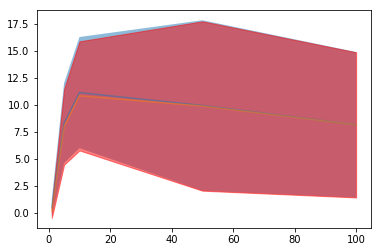

In [43]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5)
plt.plot(x,y, alpha=0.5)

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y,  alpha=0.5)


[2020-01-31 23:32:41,602] [DEBUG] - update_title_pos
[2020-01-31 23:32:41,624] [DEBUG] - update_title_pos
[2020-01-31 23:32:41,650] [DEBUG] - update_title_pos
[2020-01-31 23:32:41,668] [DEBUG] - update_title_pos
[2020-01-31 23:32:41,679] [DEBUG] - update_title_pos


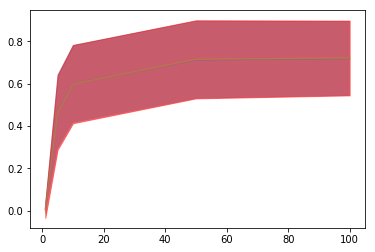

In [45]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5)
plt.plot(x,y, alpha=0.5)

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y,  alpha=0.5)


In [46]:
import compressors.compressor8  as dumb 
#import compressors.compressor8 as d 
import storages.shelve_based as db
#from importlib import reload
#reload(d)

In [48]:
import pickle
import os 
db_name = './test_db'
result = {}
for take_every in [1,5,10,50,100]:
    for word_ngrams in [True, False]:
        os.system('rm -r {0}'.format(db_name))
        dc = dumb.Compressor8Bit(db.ShelveStorage(db_name, 'c'))
        dc.fit(model, word_ngrams, take_every)
        cos, eucl = eval_model()
        result[(take_every, word_ngrams)] = cos, eucl
        with open('results_8bit.pckl', 'wb') as out:
            pickle.dump(result, out)

[2020-01-31 23:33:39,467] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [01:10<00:00, 64453.70it/s]
[2020-01-31 23:34:49,587] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [01:33<00:00, 21432.08it/s]
[2020-01-31 23:36:22,907] [DEBUG] - loading words
100%|██████████| 2519370/2519370 [03:00<00:00, 13978.00it/s]
[2020-01-31 23:39:23,147] [DEBUG] - ready
[2020-01-31 23:39:38,467] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [01:06<00:00, 68421.33it/s]
[2020-01-31 23:40:44,521] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [01:36<00:00, 20727.27it/s]
[2020-01-31 23:42:21,013] [DEBUG] - ready
/usr/local/lib/python3.5/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
[2020-01-31 23:42:34,804] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [01:11<00:00, 63143.34it/s]
[2020-01-31 23:43:46,380] [DEBUG] - loading ngrams
100%|██████████| 4

KeyboardInterrupt: 

In [49]:
import pickle
with open('results_dumb.pckl', 'rb') as inp:
    result = pickle.load(inp)

[2020-01-31 23:49:45,890] [DEBUG] - update_title_pos
[2020-01-31 23:49:45,916] [DEBUG] - update_title_pos
[2020-01-31 23:49:45,942] [DEBUG] - update_title_pos
[2020-01-31 23:49:45,963] [DEBUG] - update_title_pos
[2020-01-31 23:49:45,975] [DEBUG] - update_title_pos


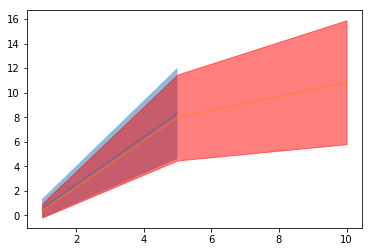

In [50]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5)
plt.plot(x,y, alpha=0.5)

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y,  alpha=0.5)


[2020-01-31 23:50:19,010] [DEBUG] - update_title_pos
[2020-01-31 23:50:19,042] [DEBUG] - update_title_pos
[2020-01-31 23:50:19,070] [DEBUG] - update_title_pos
[2020-01-31 23:50:19,092] [DEBUG] - update_title_pos
[2020-01-31 23:50:19,104] [DEBUG] - update_title_pos


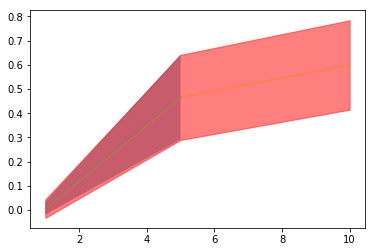

In [52]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5)
plt.plot(x,y, alpha=0.5)

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y,  alpha=0.5)


In [9]:
import compressors.compressor8 as d 
from importlib import reload
reload(d)

<module 'compressors.compressor8' from '/home/legin/ft_compress/ft_compress/compressors/compressor8.py'>

In [10]:
dc = d.Compressor8bit(model, 2500000) #~50% percents

[2020-01-12 14:35:37,861] [DEBUG] - Loading words
[2020-01-12 14:35:48,702] [WARNING] - Too many ngrams, breaking
[2020-01-12 14:35:48,702] [WARNING] - Too many ngrams, breaking
[2020-01-12 14:35:48,702] [DEBUG] - Estimating parameters
[2020-01-12 14:36:15,707] [DEBUG] - filling matrix


KeyboardInterrupt: 

In [23]:
model.get_subwords('bananananana')[0]

['<ba',
 '<ban',
 '<bana',
 '<banan',
 'ban',
 'bana',
 'banan',
 'banana',
 'ana',
 'anan',
 'anana',
 'ananan',
 'nan',
 'nana',
 'nanan',
 'nanana',
 'ana',
 'anan',
 'anana',
 'ananan',
 'nan',
 'nana',
 'nanan',
 'nanana',
 'ana',
 'anan',
 'anana',
 'ananan',
 'nan',
 'nana',
 'nanan',
 'nanana',
 'ana',
 'anan',
 'anana',
 'anana>',
 'nan',
 'nana',
 'nana>',
 'ana',
 'ana>',
 'na>']

In [0]:
v = model.get_input_vector(0)

In [0]:
v2 = np.round(255*(v-dc.min_)/(dc.max_-dc.min_)).astype(np.uint8)


In [0]:
(dc.bytes_to_vec(dc.ngrams[',']) - v).sum()

In [0]:
dc.max_, v.max()

In [0]:
dc.ngrams

In [0]:
dc.info()